# 6 The Haunted DAG & The Causal Terror

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
# R-like interface, alternatively you can import statsmodels as import statsmodels.api as sm
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import theano
import seaborn as sns

from scipy.special import logsumexp

%config InlineBackend.figure_formats = ['retina']
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
def standardize(col):
    return (col - col.mean())/col.std()

##### Code 6.1

In [3]:
np.random.seed(1914)
n = 200 # num grant proposals
p = 0.1 # proportion to select
# uncorrelated newsworthiness and trustworthiness
nw = stats.norm.rvs(size=n)
tw = stats.norm.rvs(size=n)
# select top 10% of combined scores
s = nw + tw # total score
q = np.quantile(s, 1-p) # top 10% threshold
selected = s>=q
np.corrcoef(nw[selected], tw[selected])

array([[ 1.        , -0.64839295],
       [-0.64839295,  1.        ]])

## 6.1 Multicollinearity

### 6.1.1 Multicollinear legs

##### Code 6.2

In [4]:
n = 100 # number of individuals
np.random.seed(909)
height = stats.norm.rvs(loc=10, scale=2, size=n) # sim total height of each
leg_prop = stats.uniform.rvs(loc=0.4, scale=0.1, size=n) # leg as proportion of height
leg_left = leg_prop * height + stats.norm.rvs(loc=0, scale=0.02, size=n) # sim left leg as proportion + error
leg_right = leg_prop * height + stats.norm.rvs(loc=0, scale=0.02, size=n) # sim right left as proportion + error
d = pd.DataFrame(np.array([height, leg_left, leg_right]).T, columns=["height", "leg_left", "leg_right"])

In [5]:
d.head()

,height,leg_left,leg_right
0,8.463728,4.094675,4.078446
1,9.854070,4.776475,4.687749
2,8.668694,4.192607,4.256472
3,7.523768,3.088674,3.088206
4,9.381352,4.093217,4.048181


##### Code 6.3

In [6]:
with pm.Model() as m6_1:
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    br = pm.Normal('br', mu=2, sd=10)
    mu = pm.Deterministic('mu', a + bl * d['leg_left'] + br * d['leg_right'])
    sigma = pm.Exponential('sigma', lam=1)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d['height'])
    
    trace_6_1 = pm.sample(1000, tune=1000)

pm.summary(trace_6_1, varnames=['a', 'bl', 'br', 'sigma'], alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, br, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [03:12<00:00, 10.82draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.93,0.33,0.01,0.37,1.43,1359.58,1.0
bl,-1.38,2.05,0.07,-4.47,2.18,861.47,1.0
br,3.38,2.04,0.07,-0.09,6.51,861.50,1.0
sigma,0.66,0.05,0.00,0.58,0.73,978.92,1.0


##### Code 6.4

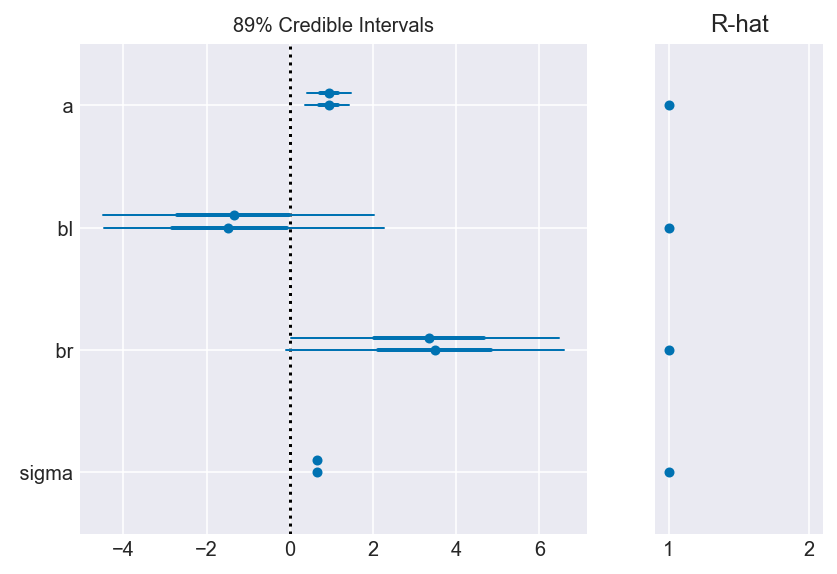

In [7]:
pm.forestplot(trace_6_1, varnames=['a', 'bl', 'br', 'sigma'], alpha=0.11);

##### Code 6.5

In [8]:
trace_6_1['bl']

array([-3.18728321, -1.99380045, -0.55464667, ..., -5.44846022,
       -2.93200934, -2.21102796])

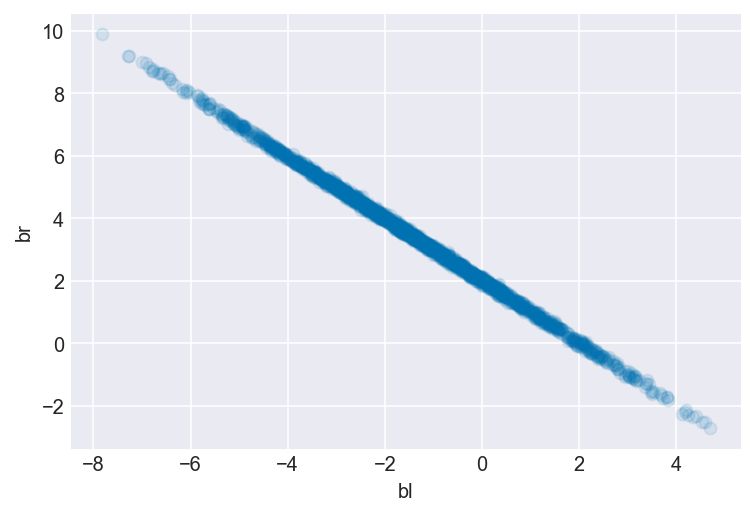

In [9]:
plt.scatter(trace_6_1['bl'], trace_6_1['br'], alpha=0.1)
plt.xlabel("bl")
plt.ylabel("br");

##### Code 6.6

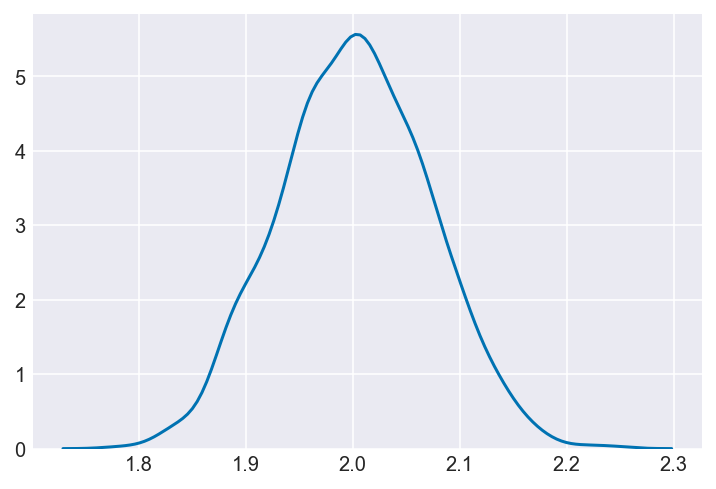

In [10]:
sum_blr = trace_6_1['bl'] + trace_6_1['br']
sns.kdeplot(sum_blr);

##### Code 6.7

In [11]:
with pm.Model() as m6_2: 
    a = pm.Normal('a', mu=10, sd=100)
    bl = pm.Normal('bl', mu=2, sd=10)
    sigma = pm.Exponential("sigma", lam=1)
    mu = pm.Deterministic("mu", a + bl * d["leg_left"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    
    trace_6_2 = pm.sample(1000, tune=1000)

pm.summary(trace_6_2, varnames=["a","bl","sigma"], alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bl, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:09<00:00, 430.13draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.82,0.33,0.01,0.29,1.33,703.65,1.0
bl,2.03,0.07,0.00,1.91,2.13,699.51,1.0
sigma,0.66,0.05,0.00,0.59,0.74,1021.85,1.0


### 6.1.2 Multicollinear milk

##### Code 6.8

In [12]:
d = pd.read_csv("Data/milk.csv", sep=";")
d["K"] = standardize(d["kcal.per.g"])
d["F"] = standardize(d["perc.fat"])
d["L"] = standardize(d["perc.lactose"])

##### Code 6.9

In [13]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m6_3:
    a = pm.Normal("a", mu=0, sd=0.2)
    bF = pm.Normal("bF", mu=0, sd=0.5)
    mu = pm.Deterministic("mu", a + bF * d["F"])
    sigma = pm.Exponential("sigma", lam=1)
    k = pm.Normal("k", mu=mu, sd=sigma, observed=d["K"])
    
    trace_6_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bF, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1052.74draws/s]


In [14]:
# kcal.per.g regressed on perc.lactose
with pm.Model() as m6_4:
    a = pm.Normal("a", mu=0, sd=0.2)
    bL = pm.Normal("bL", mu=0, sd=0.5)
    mu = pm.Deterministic("mu", a + bL * d["L"])
    sigma = pm.Exponential("sigma", lam=1)
    k = pm.Normal("k", mu=mu, sd=sigma, observed=d["K"])
    
    trace_6_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1120.96draws/s]


In [15]:
pm.summary(trace_6_3, varnames=["a", "bF", "sigma"], alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.00,0.08,0.0,-0.11,0.14,2391.35,1.0
bF,0.86,0.09,0.0,0.71,0.99,2256.96,1.0
sigma,0.49,0.07,0.0,0.39,0.59,2078.51,1.0


In [16]:
pm.summary(trace_6_4, varnames=["a", "bL", "sigma"], alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.00,0.07,0.0,-0.12,0.11,1795.78,1.0
bL,-0.90,0.07,0.0,-1.01,-0.78,1905.52,1.0
sigma,0.41,0.06,0.0,0.32,0.50,1861.12,1.0


##### Code 6.5

In [17]:
with pm.Model() as m6_5:
    a = pm.Normal("a", mu=0, sd=0.2)
    bF = pm.Normal("bF", mu=0, sd=0.5)
    bL = pm.Normal("bL", mu=0, sd=0.5)
    mu = pm.Deterministic("mu", a + bF * d["F"] + bL * d["L"])
    sigma = pm.Exponential("sigma", lam=1)
    k = pm.Normal("k", mu=mu, sd=sigma, observed=d["K"])
    
    trace_6_5 = pm.sample(1000, tune=1000)
pm.summary(trace_6_5, varnames=["a", "bL", "bF", "sigma"], alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bL, bF, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 574.47draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.00,0.07,0.00,-0.12,0.11,1599.86,1.0
bL,-0.67,0.20,0.01,-0.98,-0.36,954.93,1.0
bF,0.25,0.20,0.01,-0.06,0.55,960.66,1.0
sigma,0.41,0.06,0.00,0.32,0.50,1036.03,1.0


##### Code 6.11

In [18]:
d.columns

Index(['clade', 'species', 'kcal.per.g', 'perc.fat', 'perc.protein',
       'perc.lactose', 'mass', 'neocortex.perc', 'K', 'F', 'L'],
      dtype='object')

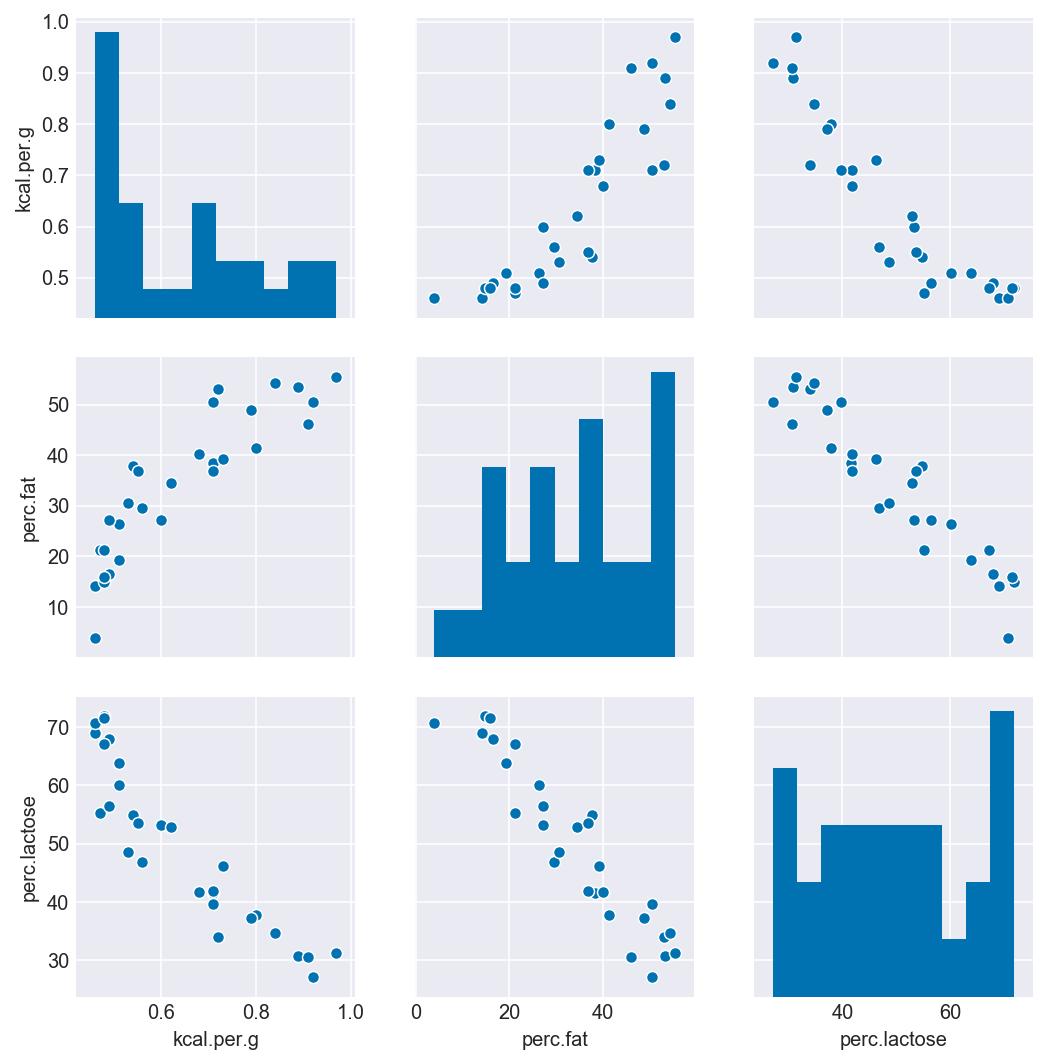

In [19]:
sns.pairplot(d[["kcal.per.g", "perc.fat", "perc.lactose"]]);

### Code 6.1.3 How bad is correlation?

In [20]:
np.corrcoef(d["perc.fat"], d["perc.lactose"])[0,1]

-0.9416373456839282

##### Code 6.13

TODO some day

## 6.2 Post-treatment bias

##### Code 6.14

In [21]:
np.random.seed(71)
# number of plants
n = 100

# simulate initial heights
h0 = stats.norm.rvs(loc=10, scale=2, size=n)

# assign treatments and simulate fungus and growth
treatment = np.concatenate([np.zeros(int(n/2), dtype=int), np.ones(int(n/2), dtype=int)])
np.random.shuffle(treatment)
fungus = stats.binom.rvs(1, 0.5 - treatment * 0.4)
h1 = h0 + stats.norm.rvs(loc= 5 - 3 * fungus)

# compose and clean data frame
d = pd.DataFrame({"h0": h0, "h1": h1, "treatment": treatment, "fungus":fungus})

In [22]:
d.describe(percentiles=[0.055, 0.945]).T.round(2)

,count,mean,std,min,5.5%,50%,94.5%,max
h0,100.0,10.15,1.67,6.09,7.43,10.12,12.43,13.89
h1,100.0,14.07,1.99,8.45,10.58,14.25,16.95,19.35
treatment,100.0,0.50,0.50,0.00,0.00,0.50,1.00,1.00
fungus,100.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00


### 6.2.1 A prior is born

##### Code 6.15

In [23]:
sim_p = stats.lognorm.rvs(0.25, loc=0, size=1000)

In [24]:
pd.DataFrame({"sim_p": sim_p}).describe(percentiles=[0.055, 0.945]).T.round(2)

,count,mean,std,min,5.5%,50%,94.5%,max
sim_p,1000.0,1.03,0.27,0.49,0.66,0.99,1.48,2.16


##### Code 6.16

In [25]:
with pm.Model() as m6_6:
    p = pm.Lognormal("p", mu=0, sigma=0.25)
    mu = pm.Deterministic("mu", h0 * p)
    sigma= pm.Exponential("sigma", lam=1)
    h1_ = pm.Normal("h1", mu=mu, sigma=sigma, observed=h1)
    
    trace_6_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, p]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1076.20draws/s]


In [26]:
pm.summary(trace_6_6, varnames=["p", "sigma"], alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
p,1.37,0.02,0.0,1.33,1.4,2129.07,1.0
sigma,1.99,0.14,0.0,1.77,2.2,1845.30,1.0


##### Code 6.17

In [27]:
with pm.Model() as m6_7:
    a = pm.Lognormal("a", mu=0, sigma=0.2)
    bt = pm.Normal("bt", mu=0, sd=0.5)
    bf = pm.Normal("bf", mu=0, sd=0.5)
    p = pm.Deterministic("p", a + bt*d["treatment"] + bf*d["fungus"])
    mu = pm.Deterministic("mu", p * d["h0"])
    sigma= pm.Exponential("sigma", lam=1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d["h1"])
    
    trace_6_7 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bf, bt, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 670.88draws/s]


In [28]:
pm.summary(trace_6_7, varnames=["a", "bt", "bf", "sigma"], alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.44,0.03,0.0,1.40,1.48,976.93,1.0
bt,0.04,0.03,0.0,-0.01,0.09,1059.41,1.0
bf,-0.27,0.03,0.0,-0.32,-0.22,1117.31,1.0
sigma,1.37,0.10,0.0,1.22,1.52,1563.19,1.0


### 6.2.2 Blocked by consequence

##### Code 6.18

In [29]:
with pm.Model() as m6_8:
    a = pm.Lognormal("a", mu=0, sigma=0.2)
    bt = pm.Normal("bt", mu=0, sd=0.5)
    p = pm.Deterministic("p", a + bt*d["treatment"])
    mu = pm.Deterministic("mu", p * d["h0"])
    sigma= pm.Exponential("sigma", lam=1)
    h1 = pm.Normal("h1", mu=mu, sigma=sigma, observed=d["h1"])
    
    trace_6_8 = pm.sample(1000, tune=1000)
pm.summary(trace_6_8, varnames=["a", "bt", "sigma"], alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bt, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 867.16draws/s] 


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.29,0.02,0.0,1.25,1.32,1200.75,1.0
bt,0.17,0.04,0.0,0.11,0.22,1080.69,1.0
sigma,1.81,0.13,0.0,1.62,2.02,1529.67,1.0


### 6.2.3 Fungus and $d$-separation

##### Code 6.19-21

Still waiting for DAG drawing library

## 6.3 Collider bias

### 6.3.1 Collider of false sorrow

##### Code 6.22

In [30]:
def peopleAreBorn(size=20):
    new_ages = np.zeros(size, dtype=int)
    new_hapiness = stats.uniform.rvs(loc=-2, scale=4, size=size)
    new_married = np.zeros(size, dtype=int)
    return pd.DataFrame({"age":new_ages, "hapiness": new_hapiness, "married": new_married})

In [31]:
def getsMarried(happiness, age):
    prob = np.minimum((happiness+3)/6, age>=18)    
    return (stats.uniform.rvs(loc=0, scale=1, size=len(happiness)) < prob) * 1

In [32]:
def updateOneYear(df, new_born=20, age_to_spain=65):
    dataframe = df[df["age"]<age_to_spain].copy()
    dataframe["age"] = dataframe["age"] + 1
    dataframe["married"] = np.maximum(dataframe["married"], getsMarried(dataframe["hapiness"], dataframe["age"]))
    return pd.concat([peopleAreBorn(new_born), dataframe])

In [33]:
def sim_happiness(years, seed, birth_per_year=20, age_to_spain=65):
    np.random.seed(seed)
    df = peopleAreBorn(birth_per_year)
    for _ in range(years-1):
        df = updateOneYear(df, birth_per_year, age_to_spain)
    return df

In [34]:
df = sim_happiness(1000, 1977)

In [35]:
df.describe(percentiles=[0.055, 0.945]).T.round(2)

,count,mean,std,min,5.5%,50%,94.5%,max
age,1320.0,32.50,19.06,0.0,3.00,32.5,62.00,65.0
hapiness,1320.0,-0.01,1.15,-2.0,-1.79,0.0,1.76,2.0
married,1320.0,0.70,0.46,0.0,0.00,1.0,1.00,1.0


TODO: Check that the above code is correct (produce FIGURE 6.5)

##### Code 6.23

In [36]:
d2 = df[df["age"]>17].copy()
d2["A"] = (d2["age"] - 18)/(65-18)

##### Code 6.24

In [37]:
with pm.Model() as m6_9:
    a = pm.Normal("a", mu=0, sd=1, shape=2)
    bA = pm.Normal("bA", mu=0, sd=2)
    mu = pm.Deterministic("mu", a[d2["married"]] +  bA * d2["A"])
    sigma = pm.Exponential("sigma", lam=1)
    hapiness = pm.Normal("hapiness", mu=mu, sd=sigma, observed=d2["hapiness"])
    
    trace_6_9 = pm.sample(1000, tune=1000)

/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
/anaconda3/envs/stat-rethink-pymc3/lib

In [38]:
pm.summary(trace_6_9, varnames=["a", "bA", "sigma"],alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a__0,-0.59,0.21,0.0,-0.90,-0.22,2208.66,1.0
a__1,0.14,0.08,0.0,0.01,0.26,1510.62,1.0
bA,-0.27,0.13,0.0,-0.46,-0.03,1429.76,1.0
sigma,1.16,0.03,0.0,1.12,1.20,2231.85,1.0


##### Code 6.25

In [39]:
with pm.Model() as m6_10:
    a = pm.Normal("a", mu=0, sd=1)
    bA = pm.Normal("bA", mu=0, sd=2)
    mu = pm.Deterministic("mu", a +  bA * d2["A"])
    sigma = pm.Exponential("sigma", lam=1)
    hapiness = pm.Normal("hapiness", mu=mu, sd=sigma, observed=d2["hapiness"])
    
    trace_6_10 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bA, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 679.88draws/s]


In [40]:
pm.summary(trace_6_10, varnames=["a", "bA", "sigma"],alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.06,0.07,0.0,-0.07,0.17,868.05,1.0
bA,-0.14,0.13,0.0,-0.35,0.04,870.59,1.0
sigma,1.16,0.03,0.0,1.12,1.21,1016.68,1.0


### The haunted DAG

##### Code 6.26

In [41]:
n = 200 # number of grandparent-parent-child triads
b_GP = 1 # direct effect of G on P
b_GC = 0 # direct effect of G on C
b_PC = 1 # direct effect of P on C
b_U = 2 # direct effect of U on P and C

##### Code 6.27

In [43]:
np.random.seed(1)
u = 2*stats.bernoulli.rvs(p=0.5, size=n) - 1
g = stats.norm.rvs(size=n)
p = stats.norm.rvs(loc=b_GP * g + b_U * u)
c = stats.norm.rvs(loc=b_PC * p + b_GC * g + b_U * u)
d = pd.DataFrame({"C":c, "P":p, "G":g, "U":u})

In [44]:
d.head()

,C,P,G,U
0,-4.366224,-2.090378,0.077821,-1
1,5.673156,2.444200,0.618380,1
2,-1.996635,-1.306341,0.232495,-1
3,-5.648414,-2.493431,0.682551,-1
4,-3.477622,-1.299990,-0.310117,-1


##### Code 6.28

In [45]:
with pm.Model() as m6_11:
    a = pm.Normal("a", mu=0, sd=1)
    b_PC = pm.Normal("b_PC", mu=0, sd=1)
    b_GC = pm.Normal("b_GC", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_PC * d["P"] + b_GC * d["G"])
    sigma= pm.Exponential("sigma", lam=1)
    c = pm.Normal("C", mu=mu, sd=sigma, observed=d["C"])
    
    trace_6_11 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_GC, b_PC, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 769.92draws/s] 


In [46]:
pm.summary(trace_6_11, varnames=["a", "b_PC", "b_GC", "sigma"], alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-0.01,0.09,0.0,-0.16,0.13,2625.62,1.0
b_PC,1.84,0.04,0.0,1.78,1.92,1976.12,1.0
b_GC,-0.77,0.09,0.0,-0.93,-0.63,2065.22,1.0
sigma,1.30,0.07,0.0,1.19,1.40,2732.82,1.0


##### Code 6.29

In [47]:
with pm.Model() as m6_12:
    a = pm.Normal("a", mu=0, sd=1)
    b_PC = pm.Normal("b_PC", mu=0, sd=1)
    b_GC = pm.Normal("b_GC", mu=0, sd=1)
    b_U = pm.Normal("b_U", mu=0, sd=1)
    mu = pm.Deterministic("mu", a + b_PC * d["P"] + b_GC * d["G"] + b_U * d["U"])
    sigma= pm.Exponential("sigma", lam=1)
    c = pm.Normal("C", mu=mu, sd=sigma, observed=d["C"])
    
    trace_6_12 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b_U, b_GC, b_PC, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 857.19draws/s] 


In [48]:
pm.summary(trace_6_12, varnames=["a", "b_PC", "b_GC", "b_U", "sigma"], alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.00,0.07,0.0,-0.11,0.12,2178.73,1.0
b_PC,1.17,0.07,0.0,1.05,1.27,885.09,1.0
b_GC,-0.07,0.10,0.0,-0.23,0.09,1014.82,1.0
b_U,1.66,0.15,0.0,1.42,1.89,897.76,1.0
sigma,1.03,0.05,0.0,0.95,1.12,2415.60,1.0


## 6.4 Confronting confounding

### 6.4.1 Shutting the backdoor

### 6.4.2 Two roads

##### Code 6.30

In [49]:
# Nope

### 6.4.3 Backdoor waffles

##### Code 6.31

In [50]:
# Nay

##### Code 6.32

In [51]:
# No way

## 6.5 Summary

## 6.6 Practice

TODO

In [52]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running   and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.15.4
Pandas 0.24.1
SciPy 1.2.0
Matplotlib 3.0.2



/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  


HERE I AM

This is now part of Chapter 7

#### Code 6.2

In [54]:
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#### Code 6.3

In [55]:
1 - m_6_1.resid.var()/d.brain.var()

# m_6_1.summary() check the value for R-squared

0.490158047949084

#### Code 6.4

In [56]:
m_6_2 = smf.ols('brain ~ mass + I(mass**2)', data=d).fit()

#### Code 6.5

In [57]:
m_6_3 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3)', data=d).fit()
m_6_4 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4)', data=d).fit()
m_6_5 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d).fit()
m_6_6 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5) + I(mass**6)', data=d).fit()

#### Code 6.6

In [58]:
m_6_7 = smf.ols('brain ~ 1', data=d).fit()

#### Code 6.7

In [59]:
d_new = d.drop(d.index[-1])

#### Code 6.8

/anaconda3/envs/stat-rethink-pymc3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


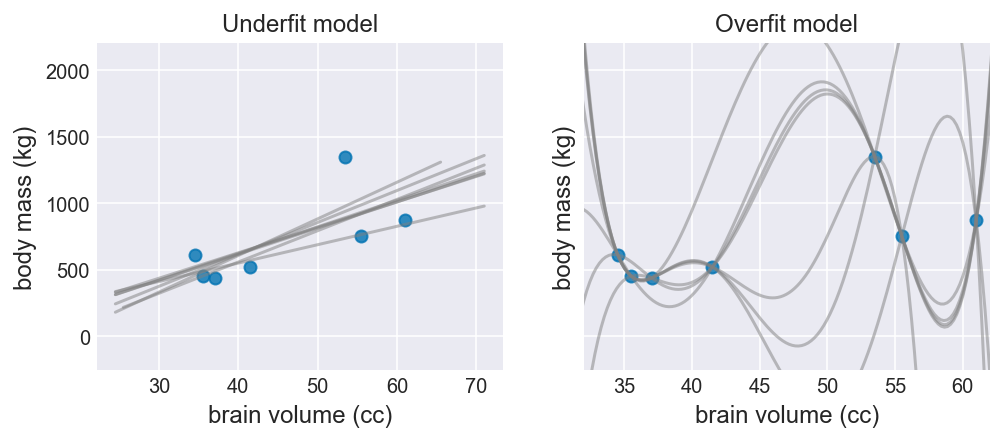

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.scatter(d.mass, d.brain, alpha=0.8)
ax2.scatter(d.mass, d.brain, alpha=0.8)
for i in range(len(d)):
    d_new = d.drop(d.index[-i])
    m0 = smf.ols('brain ~ mass', d_new).fit()
    # need to calculate regression line
    # need to add intercept term explicitly
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min() - 10, x.mass.max() + 10, 50)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m0.predict(x_pred2)  # calculate predicted values
    ax1.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax1.set_ylabel('body mass (kg)', fontsize=12);
    ax1.set_xlabel('brain volume (cc)', fontsize=12)
    ax1.set_title('Underfit model')
    
    # fifth order model
    m1 = smf.ols('brain ~ mass + I(mass**2) + I(mass**3) + I(mass**4) + I(mass**5)', data=d_new).fit()
    x = sm.add_constant(d_new.mass)  # add constant to new data frame with mass
    x_pred = pd.DataFrame({'mass': np.linspace(x.mass.min()-10, x.mass.max()+10, 200)})  # create linspace dataframe
    x_pred2 = sm.add_constant(x_pred)  # add constant to newly created linspace dataframe
    y_pred = m1.predict(x_pred2)  # calculate predicted values from fitted model
    ax2.plot(x_pred, y_pred, 'gray', alpha=.5)
    ax2.set_xlim(32,62)
    ax2.set_ylim(-250, 2200)
    ax2.set_ylabel('body mass (kg)', fontsize=12);
    ax2.set_xlabel('brain volume (cc)', fontsize=12)
    ax2.set_title('Overfit model')
plt.show()

#### Code 6.9

In [61]:
p = (0.3, 0.7)
-sum(p * np.log(p))

0.6108643020548935

#### Code 6.10

In [62]:
# fit model
m_6_1 = smf.ols('brain ~ mass', data=d).fit()

#compute de deviance by cheating
-2 * m_6_1.llf

94.92498968588757

#### Code 6.11

In [63]:
# standarize the mass before fitting
d['mass_s'] = d['mass'] - np.mean(d['mass'] / np.std(d['mass']))

with pm.Model() as m_6_8 :
    a = pm.Normal('a', mu=np.mean(d['brain']), sd=10)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, np.std(d['brain']) * 10)
    mu = pm.Deterministic('mu', a + b * d['mass_s'])
    brain = pm.Normal('brain', mu = mu, sd = sigma, observed = d['brain'])
    m_6_8 = pm.sample(2000, tune=5000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains: 100%|██████████| 14000/14000 [00:09<00:00, 1446.97draws/s]


In [64]:
theta = pm.summary(m_6_8)['mean'][:3]

In [65]:
#compute deviance
dev = - 2 * sum(stats.norm.logpdf(d['brain'], loc = theta[0] + theta[1] * d['mass_s']  , scale = theta[2]))
dev 

100.57142136990691

#### Code 6.12

[This](https://github.com/rmcelreath/rethinking/blob/a309712d904d1db7af1e08a76c521ab994006fd5/R/sim_train_test.R) is the original function.

In [66]:
# This function only works with number of parameters >= 2 

def sim_train_test(N=20, k=3, rho=[0.15, -0.4], b_sigma=100):
    
    n_dim = 1 + len(rho)
    if n_dim < k:
        n_dim = k
    Rho = np.diag(np.ones(n_dim))
    Rho[0, 1:3:1] = rho
    i_lower = np.tril_indices(n_dim, -1)
    Rho[i_lower] = Rho.T[i_lower]
    
    x_train = stats.multivariate_normal.rvs(cov=Rho, size=N)
    x_test = stats.multivariate_normal.rvs(cov=Rho, size=N)
    
    mm_train = np.ones((N,1))
    
    np.concatenate([mm_train, x_train[:, 1:k]], axis=1)
    
    #Using pymc3
    
    with pm.Model() as m_sim:
        vec_V = pm.MvNormal('vec_V', mu=0, cov=b_sigma * np.eye(n_dim), 
                            shape=(1, n_dim), testval=np.random.randn(1, n_dim)*.01)
        mu = pm.Deterministic('mu', 0 + pm.math.dot(x_train, vec_V.T))
        y = pm.Normal('y', mu=mu, sd=1, observed=x_train[:, 0])

    with m_sim:
        trace_m_sim = pm.sample()
        
    vec = pm.summary(trace_m_sim)['mean'][:n_dim]
    vec = np.array([i for i in vec]).reshape(n_dim, -1)
    
    dev_train = - 2 * sum(stats.norm.logpdf(x_train, loc = np.matmul(x_train, vec), scale = 1))    
    
    mm_test = np.ones((N,1))
    
    mm_test = np.concatenate([mm_test, x_test[:, 1:k +1]], axis=1)
    
    dev_test = - 2 * sum(stats.norm.logpdf(x_test[:,0], loc = np.matmul(mm_test, vec), scale = 1))    
    
    return np.mean(dev_train), np.mean(dev_test)

In [67]:
n = 20
tries = 10
param = 6
r = np.zeros(shape=(param - 1, 4))

train = []
test = []

for j in range(2, param + 1):
    print(j)
    for i in range(1, tries + 1):
        tr, te = sim_train_test(N=n, k=param)
        train.append(tr), test.append(te)
    r[j -2, :] = np.mean(train), np.std(train, ddof=1), np.mean(test), np.std(test, ddof=1)

2


KeyboardInterrupt: 

#### Code 6.14

In [ ]:
num_param = np.arange(2, param + 1)

plt.figure(figsize=(10, 6))
plt.scatter(num_param, r[:, 0], color='C0')
plt.xticks(num_param)

for j in range(param - 1):
    plt.vlines(num_param[j], r[j,0] - r[j, 1], r[j,0] + r[j,1], color='mediumblue', 
               zorder=-1, alpha=0.80)

plt.scatter(num_param + 0.1, r[:, 2], facecolors='none', edgecolors='k')

for j in range(param - 1):
    plt.vlines(num_param[j] + 0.1, r[j,2] - r[j, 3], r[j,2] + r[j,3], color='k', 
               zorder=-2, alpha=0.70)    

dist = 0.20
plt.text(num_param[1] - dist, r[1, 0] - dist, 'in', color='C0', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] - dist, 'out', color='k', fontsize=13)
plt.text(num_param[1] + dist, r[1, 2] + r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.text(num_param[1] + dist, r[1, 2] - r[1,3] - dist, '+1 SD', color='k', fontsize=10)
plt.xlabel('Number of parameters', fontsize=14)
plt.ylabel('Deviance', fontsize=14)
plt.title('N = {}'.format(n), fontsize=14)
plt.show()

#### Code 6.15

In [ ]:
data = pd.read_csv('Data/cars.csv', sep=',')

In [ ]:
with pm.Model() as m_6_15 :
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=10)
    sigma = pm.Uniform('sigma', 0, 30)
    mu = pm.Deterministic('mu', a + b * data['speed'])
    dist = pm.Normal('dist', mu=mu, sd=sigma, observed = data['dist'])
    m_6_15 = pm.sample(5000, tune=10000)

#### Code 6.16

In [ ]:
n_samples = 1000
n_cases = data.shape[0]
ll = np.zeros((n_cases, n_samples))

In [ ]:
for s in range(0, n_samples):
    mu = m_6_15['a'][s] + m_6_15['b'][s] * data['speed']
    p_ = stats.norm.logpdf(data['dist'], loc=mu, scale=m_6_15['sigma'][s])
    ll[:,s] = p_

#### Code 6.17

In [ ]:
n_cases = data.shape[0]
lppd = np.zeros((n_cases))
for a in range(1, n_cases):
    lppd[a,] = logsumexp(ll[a,]) - np.log(n_samples)

#### Code 6.18

In [ ]:
pWAIC = np.zeros((n_cases))
for i in range(1, n_cases):
    pWAIC[i,] = np.var(ll[i,])

#### Code 6.19

In [ ]:
- 2 * (sum(lppd) - sum(pWAIC))

#### Code 6.20

In [ ]:
waic_vec = - 2 * (lppd - pWAIC)
np.sqrt(n_cases * np.var(waic_vec))

#### Code 6.21

In [ ]:
d = pd.read_csv('Data/milk.csv', sep=';')
d['neocortex'] = d['neocortex.perc'] / 100
d.dropna(inplace=True)
d.shape

#### Code 6.22

In [ ]:
a_start = d['kcal.per.g'].mean()
sigma_start = d['kcal.per.g'].std()

In [ ]:
mass_shared = theano.shared(np.log(d['mass'].values))
neocortex_shared = theano.shared(d['neocortex'].values)

with pm.Model() as m6_11:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    mu = alpha + 0 * neocortex_shared
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_11 = pm.sample(1000, tune=1000)    

with pm.Model() as m6_12:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma',beta=10, testval=sigma_start)
    mu = alpha + beta * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_12 = pm.sample(5000, tune=15000)
    
with pm.Model() as m6_13:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta * mass_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_13 = pm.sample(1000, tune=1000)
    
with pm.Model() as m6_14:
    alpha = pm.Normal('alpha', mu=0, sd=10, testval=a_start)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    sigma = pm.HalfCauchy('sigma', beta=10, testval=sigma_start)
    mu = alpha + beta[0] * mass_shared + beta[1] * neocortex_shared
    kcal = pm.Normal('kcal', mu=mu, sd=sigma, observed=d['kcal.per.g'])
    trace_m6_14 = pm.sample(5000, tune=15000)

#### Code 6.23

In [ ]:
pm.waic(trace_m6_14, m6_14)

#### Code 6.24

In [ ]:

compare_df = pm.compare({m6_11 : trace_m6_11,
                         m6_12 : trace_m6_12,
                         m6_13 : trace_m6_13,
                         m6_14 : trace_m6_14}, method='pseudo-BMA')

compare_df.loc[:,'model'] = pd.Series(['m6.11', 'm6.12', 'm6.13', 'm6.14'])
compare_df = compare_df.set_index('model')
compare_df

#### Code 6.25

In [ ]:
pm.compareplot(compare_df);

#### Code 6.26

In [ ]:
diff = np.random.normal(loc=6.7, scale=7.26, size=100000)
sum(diff[diff<0]) / 100000

#### Code 6.27

Compare function already checks number of observations to be equal.

In [ ]:
coeftab = pd.DataFrame({'m6_11': pm.summary(trace_m6_11)['mean'],
                        'm6_12': pm.summary(trace_m6_12)['mean'],
                        'm6_13': pm.summary(trace_m6_13)['mean'],
                        'm6_14': pm.summary(trace_m6_14)['mean']})
coeftab

#### Code 6.28

In [ ]:
traces = [trace_m6_11, trace_m6_12, trace_m6_13, trace_m6_14]   
models = [m6_11, m6_12, m6_13, m6_14]

In [ ]:
plt.figure(figsize=(10, 8))
pm.forestplot(traces, plot_kwargs={'fontsize':14});

#### Code 6.29

In [ ]:
kcal_per_g = np.repeat(0, 30) # empty outcome
neocortex = np.linspace(0.5, 0.8, 30) # sequence of neocortex
mass = np.repeat(4.5, 30)     # average mass

In [ ]:
mass_shared.set_value(np.log(mass))
neocortex_shared.set_value(neocortex)
post_pred = pm.sample_ppc(trace_m6_14, samples=10000, model=m6_14)

#### Code 6.30

In [ ]:
milk_ensemble = pm.sample_ppc_w(traces, 10000, 
                                models, weights=compare_df.weight.sort_index(ascending=True))

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(neocortex, post_pred['kcal'].mean(0), ls='--', color='C2')
hpd_post_pred = pm.hpd(post_pred['kcal'])
plt.plot(neocortex,hpd_post_pred[:,0], ls='--', color='C2')
plt.plot(neocortex,hpd_post_pred[:,], ls='--', color='C2')

plt.plot(neocortex, milk_ensemble['kcal'].mean(0), color='C0')
hpd_av = pm.hpd(milk_ensemble['kcal'])
plt.fill_between(neocortex, hpd_av[:,0], hpd_av[:,1], alpha=0.1, color='C0')

plt.scatter(d['neocortex'], d['kcal.per.g'], facecolor='None', edgecolors='C0')

plt.ylim(0.3, 1)
plt.xlabel('neocortex', fontsize=16)
plt.ylabel('kcal.per.g', fontsize=16);

In [ ]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))